# Übung 11

**Gruppenname:**

*Name Ihrer Gruppe*

Gehen Sie wie folgt vor:

1. Bitte benennen Sie jetzt dieses Jupyter Notebook um (z.B. über `File -> Rename`):

   Namensschema: `Gruppenname-X`. Ersetzen Sie "X" mit der oben angegebenen Nummer der Übung.

   - Beispiel 1: Team REZA bearbeitet Übung 2. Das Notebook heißt: REZA-2.
   - Beispiel 2: Sie sind keinem Team zugeordnet (nicht empfehlenswert) und bearbeiten Übung 2: Ihr Notebook heißt: Nachname-2.


2. Tragen Sie Ihren Gruppennamen auch ganz oben bei "Name Ihrer Gruppe" ein.

3. Bearbeiten Sie dann dieses Notebook. Vergessen Sie dabei nicht, das Jupyter Notebook regelmäßig zu speichern (z.B. über `Strg + S` oder über `File -> Save and Checkpoint`).

### In dieser Übung ...

... werden wir uns mit Merkmalen (Features) und einfachen Modellen Klassifikatoren erzeugen und die Genauigkeit dieser Modelle mit verschiedenen Metriken bewerten. In Übung 11.1 und 11.2 werden wir uns mit Schwellwert-basierten Modellen beschäftigen. Übung 11.3 ist optional und behandelt die Klassifikation über eine einfache Form des Nächste Nachbarn Modells. Ziel aller Übungen ist es, Sie mit daten-getriebener Modellierung und der Evaluation von Klassifikatoren vertraut zu machen.

### 11.1 Frau und Mann (EDA, ROC, AUC)

In dieser Übung werden wir uns mit den Daten des [National Health and Nutrition Examination Survey](https://de.wikipedia.org/wiki/National_Health_and_Nutrition_Examination_Survey) aus den Jahren 2009-2010 beschäftigen, die verschiedene Gesundheitsdaten der amerikanischen Bevölkerung umfassen. Wir werden zunächst in einer explorativen Datenanalyse (EDA) den Datensatz untersuchen. In einem zweiten Schritt werden wir daran arbeiten, mithilfe von Merkmalen (Features) Frauen und Männer zu unterscheiden, ohne dabei die Angabe des Geschlechts (Merkmal *"Gender"*) in den Daten zu nutzen. Das Resultat ist ein ganz einfaches Klassifikationsmodell, dessen Genauigkeit wir mithilfe verschiedener Metriken untersuchen werden.

**Ihre Daten**

* Sie finden die Daten, die Sie für diese Übung benötigen, [hier](https://data.bialonski.de/ds/nhanes-data.csv).

**Ihre Aufgaben**

(1) Importieren Sie die Daten und untersuchen Sie: Welche Merkmale (Features) enthält der Datensatz? (Hinweis: Das *Gender*-Merkmal kodiert, ob es sich um einen Mann (1) oder um eine Frau (0) handelt.)

In [58]:
import pandas as pd

dataframe = pd.read_csv('nhanes-data.csv', sep='\t')

In [59]:
dataframe.head()

,Gender,Age,Weight,Height,Leg_Length,Arm_Length,Arm_circum,Waist
0,0,241,64.7,163,34.2,36.2,29.0,89.6
1,0,241,54.0,153,37.2,34.0,26.1,85.5
2,1,241,61.4,165,37.7,35.0,31.4,70.1
3,0,241,74.0,171,37.9,36.2,29.8,91.1
4,0,241,63.6,159,38.1,34.0,29.2,74.3


(2) Führen Sie eine EDA auf den Daten (zunächst ohne das *Gender* Merkmal) durch. Erstellen Sie unter anderem eine [Scattermatrix](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html) und erzeugen Sie auch paarweise [Korrelationskoeffizienten](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) (Pearson), um zu untersuchen, ob es Zusammenhänge zwischen den Merkmalen gibt. Notieren Sie hier Ihre Beobachtungen.

,Age,Weight,Height,Leg_Length,Arm_Length,Arm_circum,Waist
Age,1.000000,0.017480,-0.105107,-0.268362,0.053667,0.009340,0.227538
Weight,0.017480,1.000000,0.442543,0.237047,0.584044,0.859518,0.891869
Height,-0.105107,0.442543,1.000000,0.745212,0.799729,0.212407,0.181536
Leg_Length,-0.268362,0.237047,0.745212,1.000000,0.612864,0.075998,-0.028937
Arm_Length,0.053667,0.584044,0.799729,0.612864,1.000000,0.434724,0.401728
Arm_circum,0.009340,0.859518,0.212407,0.075998,0.434724,1.000000,0.820541
Waist,0.227538,0.891869,0.181536,-0.028937,0.401728,0.820541,1.000000


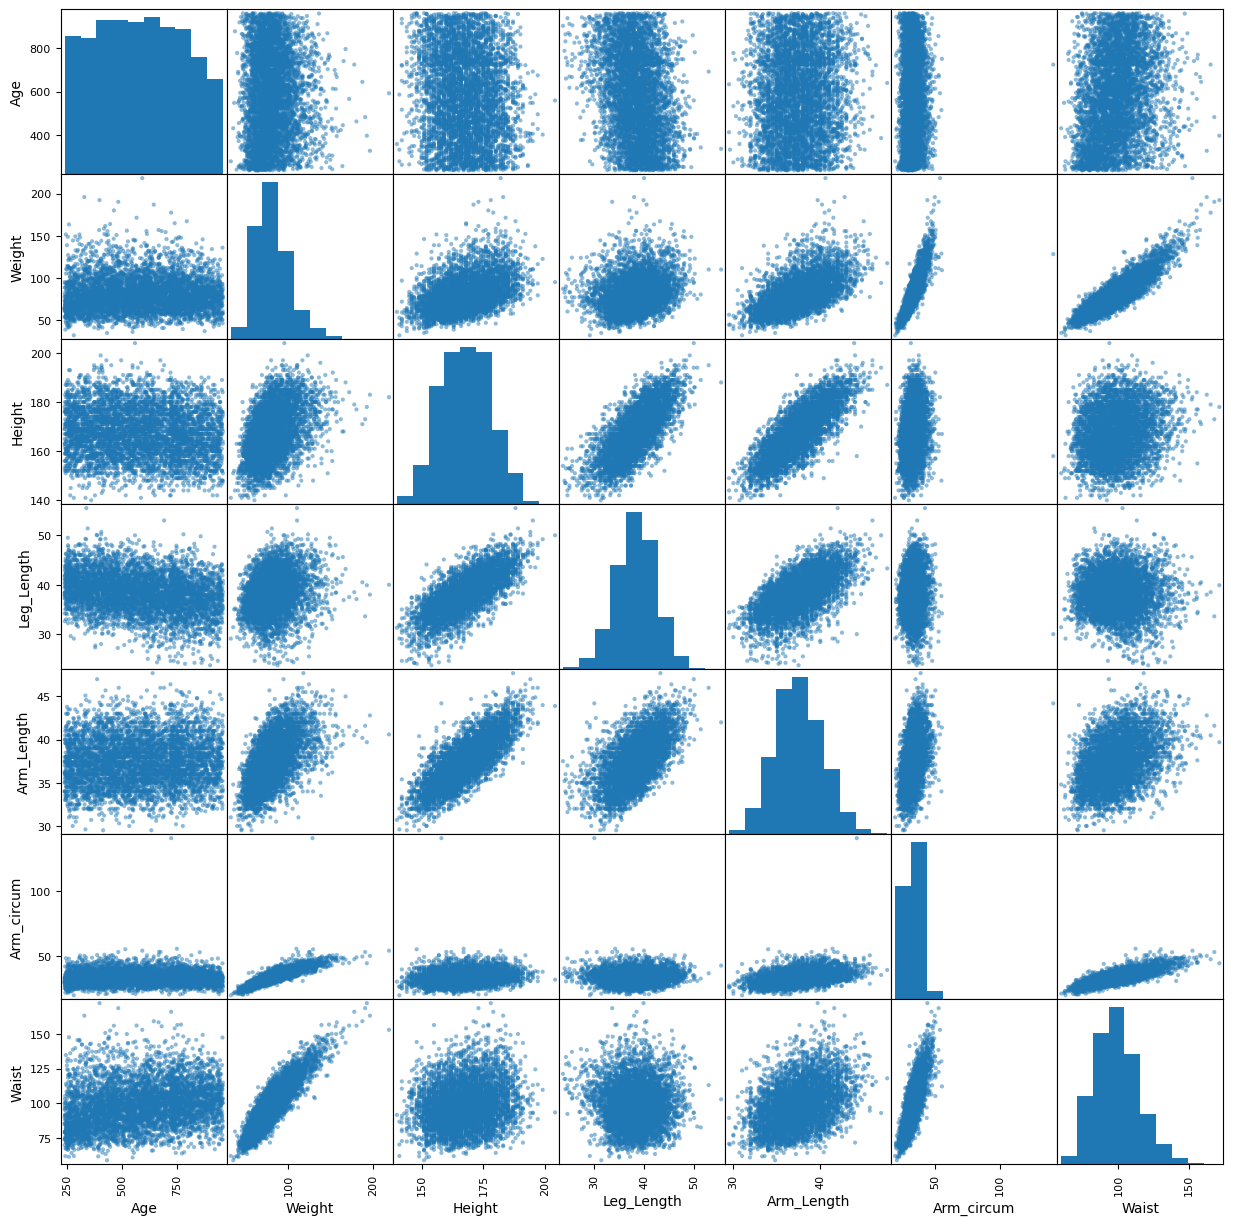

In [60]:
df_without_gender = dataframe.drop('Gender', axis=1)
pd.plotting.scatter_matrix(df_without_gender, figsize=(15,15))
df_without_gender.corr()


Korrelationen beobachtet bei
- Armumfang <-> Gewicht
- Gewicht <-> Taillenumfang
- Höhe <-> Beinlänge
- Höhe <-> Armlänge
- Armlänge <-> Beinlänge

Keine große Überraschung also

(3) Als Fortsetzung zu Schritt (2): Welche Vermutungen haben Sie, die die beobachtete Korrelation zwischen Alter und Körpergröße sowie zwischen Gewicht und Taillenumfang erklären könnte?

- Alter <-> Körpergröße hat kaum eine Korrelation hier. Ist das "Fenster" für Alter so klein, dass kleine Kinder gar nicht mit drin sind?
- Gewicht <-> Taillenumfang ist logisch, je mehr man wiegt, desto mehr Umfang hat man. ist doch klar.

Sie haben bisher die Schritte einer Explorativen Datenanalyse (EDA) nachvollzogen, in der es darum geht, die Daten kennenzulernen (und ggf. interessante Hypothesen und Fragen zu generieren). Im nächsten Schritt wollen wir mit den Daten etwas erreichen: Wir möchten anhand der Merkmale entscheiden können, ob es sich um eine Frau oder einen Mann handelt (unser Ziel ist also eine binäre Klassifikation). Sobald wir mit einem konkreten Ziel an die Daten herantreten, ändert sich unser Blick auf die Daten. Wir befinden uns in der *Feature Engineering* (Merkmalsgenerierung) Phase, in der wir nach Eigenschaften suchen, um unser Ziel zu erreichen.

(4) Erzeugen Sie jeweils einen DataFrame für die Datensätze aller Frauen sowie für die Datensätze aller Männer. Untersuchen Sie, ob Sie Merkmale (außer *gender*) in den Daten finden, mit denen Sie zwischen den Geschlechtern unterscheiden können. Nutzen Sie dazu die Mittel der EDA, also Summary Statistics, Box-Plots, und so weiter. Notieren Sie sich vielversprechende Merkmale, die Ihnen die Unterscheidung zwischen den Geschlechtern erlauben könnten.

MEAN Values:
women:
Age           583.269094
Weight         75.907163
Height        160.981005
Leg_Length     36.327107
Arm_Length     35.964266
Arm_circum     32.348912
Waist          96.645606
dtype: float64
men:
Age           585.944943
Weight         87.102896
Height        174.413540
Leg_Length     40.387235
Arm_Length     39.043515
Arm_circum     34.013825
Waist         101.076794
dtype: float64
MIN Values:
women:
Age           241.0
Weight         32.4
Height        140.0
Leg_Length     23.7
Arm_Length     29.5
Arm_circum     19.5
Waist          59.1
dtype: float64
men:
Age           241.0
Weight         43.1
Height        142.0
Leg_Length     29.0
Arm_Length     31.5
Arm_circum     20.3
Waist          64.4
dtype: float64
MAX Values:
women:
Age           959.0
Weight        190.2
Height        194.0
Leg_Length     47.7
Arm_Length     44.2
Arm_circum    141.1
Waist         168.4
dtype: float64
men:
Age           959.0
Weight        218.2
Height        204.0
Leg_Length     55.5
Ar

array([[<Axes: title={'center': 'Age'}, xlabel='[Gender]'>,
        <Axes: title={'center': 'Arm_Length'}, xlabel='[Gender]'>,
        <Axes: title={'center': 'Arm_circum'}, xlabel='[Gender]'>],
       [<Axes: title={'center': 'Height'}, xlabel='[Gender]'>,
        <Axes: title={'center': 'Leg_Length'}, xlabel='[Gender]'>,
        <Axes: title={'center': 'Waist'}, xlabel='[Gender]'>],
       [<Axes: title={'center': 'Weight'}, xlabel='[Gender]'>, <Axes: >,
        <Axes: >]], dtype=object)

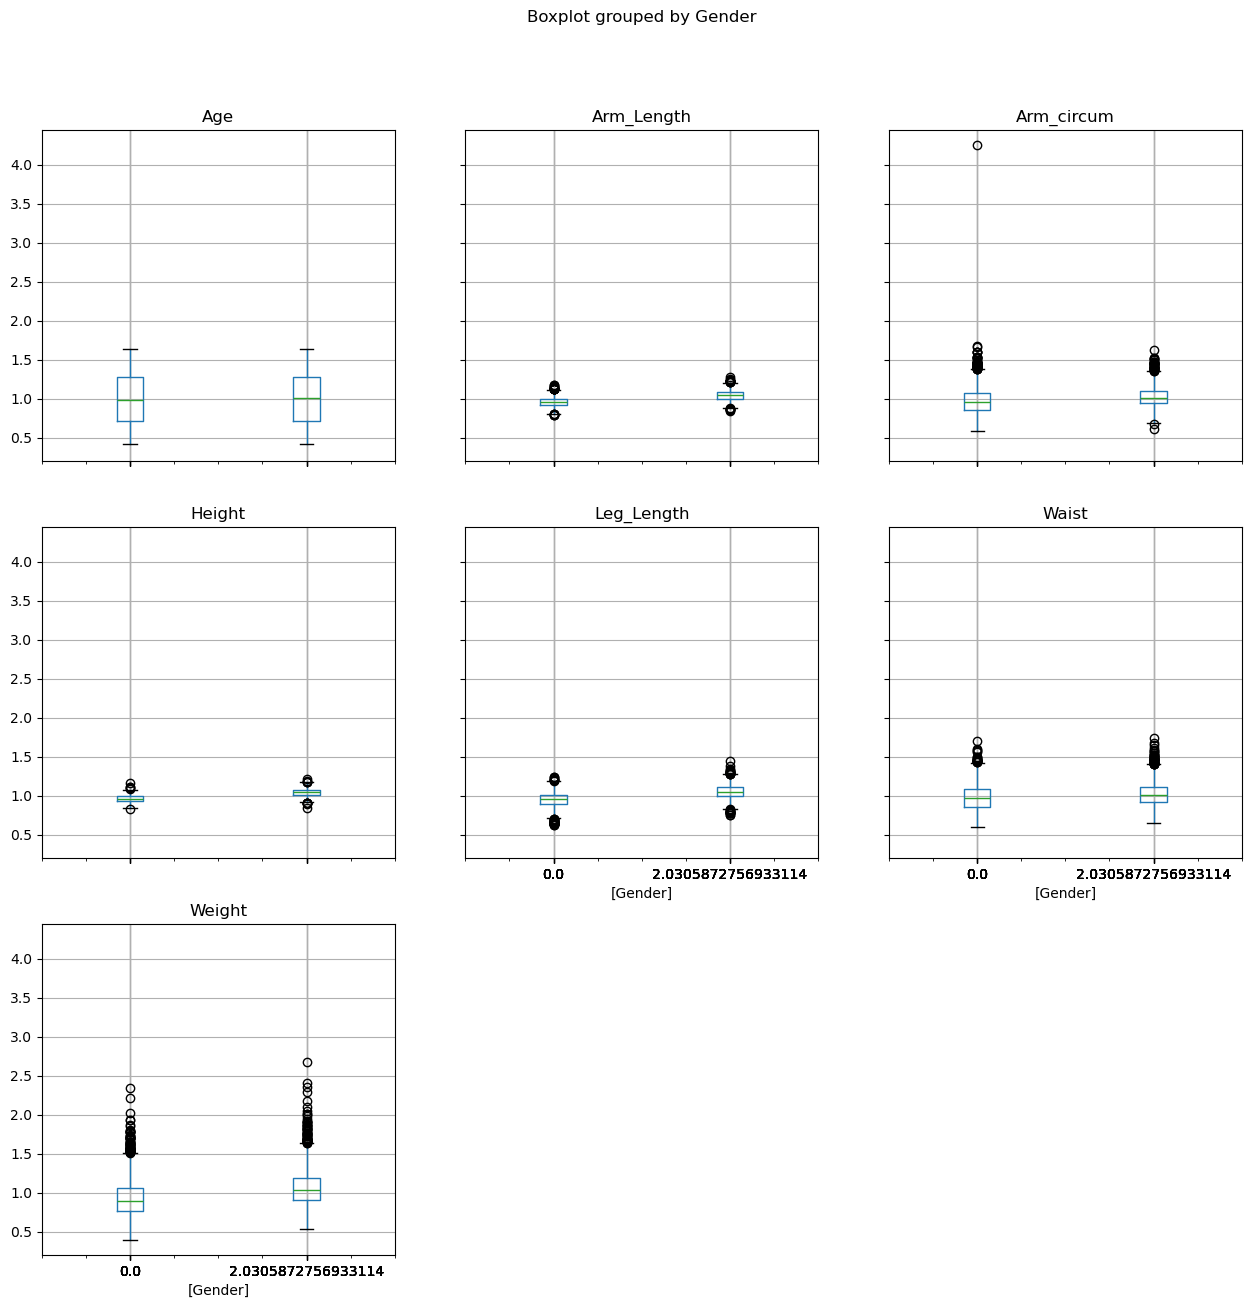

In [61]:
df_women = dataframe[dataframe['Gender'] == 0].drop('Gender', axis=1)
df_men = dataframe[dataframe['Gender'] == 1].drop('Gender', axis=1)

#print(df_women.head())
#print(df_men.head())

# summary staticstics
print("MEAN Values:")
print("women:")
print(df_women.mean())

print("men:")
print(df_men.mean())

print("MIN Values:")
print("women:")
print(df_women.min())

print("men:")
print(df_men.min())

print("MAX Values:")
print("women:")
print(df_women.max())

print("men:")
print(df_men.max())

# box plots

# dataframe.boxplot(by='Gender', figsize=(15,15)) Dieser plot ist doof. Der erste Plot (Age) bestimmt die Größe der anderen Plots

dataframe_normalized = dataframe/dataframe.mean()

dataframe_normalized.boxplot(by='Gender', figsize=(15,15))

Im nachfolgenden Schritt gebe ich Ihnen ein Merkmal vor, welches Sie sich im Folgenden anschauen werden. Ihre Arbeit in Schritt (4) war aber nicht vergebens. Wir kommen darauf später noch zurück.   

(5) Erzeugen Sie ein [Histogramm](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html), welches die Verteilung der Körpergrößen von Männern und von Frauen darstellt.

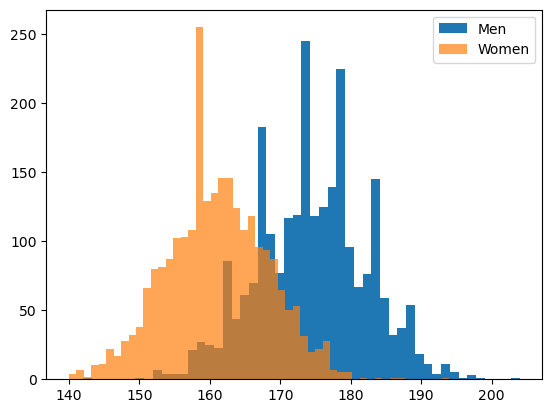

In [62]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(df_men['Height'], bins = 'sqrt')
plt.hist(df_women['Height'], bins = 'sqrt', alpha=0.7)
plt.legend(["Men","Women"])
plt.show()

(6) Wir werden ein einfaches Schwellwert-Modell konstruieren, um zwischen Männern und Frauen zu unterscheiden. Dieser sogenannte Klassifikator wird mithilfe eines Schwellwerts und eines Merkmals entscheiden, ob der Datensatz von einer Frau oder einem Mann stammt. Betrachten Sie die Abbildung aus Schritt (5). Notieren Sie sich hier den Schwellwert, den Sie nutzen würden, um alle Datensätze mit Körpergrößen größer als Ihr Schwellwert als Männer zu klassifizieren.

In [63]:
schwellwert = 170

Der Schwellwert entscheidet darüber, wie gut oder wie schlecht ihr Klassifikator zwischen Frauen und Männern unterscheiden kann. Wir werden nun untersuchen, welche Genauigkeit unser Klassifikator hat und dabei auch einen Schwellwert finden, der die Genauigkeit des Klassifikators maximiert.

(7) Sie haben in Schritt (5) beobachtet, dass Männer (zumindest in dem von Ihnen untersuchten US-amerikanischen Datensatz) tendenziell etwas größer sind als Frauen. Sei $P$ die Anzahl der Männer und $N$ die Anzahl der Frauen im Datensatz. Bestimmen Sie die Wahr-Positiv-Rate (*True Positive Rate*, TPR) sowie die Falsch-Positiv-Rate (*False Positive Rate*, FPR) für den Schwellwert, für den Sie sich in Schritt (6) entschieden haben. Für die Definition von TPR und FPR schauen Sie bitte in die Vorlesungsfolien. Interpretieren Sie kurz Ihre erhaltenen Werte. (1-2 Sätze).

In [68]:
P = df_men.shape[0]
N = df_women.shape[0]
TP = df_men[df_men['Height'] >= schwellwert].shape[0]
FP = df_women[df_women['Height'] >= schwellwert].shape[0]

TPR = TP / P
FPR = FP / N
print("TPR =", TPR)
print("FPR =", FPR)

TPR = 0.7283849918433931
FPR = 0.11515631183221212


(8) Wir wollen nun untersuchen, wie gut sich die Körpergröße für die Unterscheidung zwischen Männern und Frauen eignet, und welcher Schwellwert hier optimal ist. Dazu werden Sie für eine Menge von Schwellwerten die zugehörigen TPR und FPR-Werte bestimmen. Erstellen Sie zunächst eine Menge von Schwellwerten. Hinweis: Die Daten können Ihnen dabei helfen, Schwellwerte zu definieren.

(9) Bestimmen Sie TPR und FPR für Ihre Schwellwerte aus Schritt (8). Tragen Sie in einem Plot die TPR-Werte (y-Achse) gegen die FPR-Werte (x-Achse) auf und zeichnen Sie zusätzlich die Raumdiagonale ein. Vergessen Sie nicht, Ihren Plot zu beschriften. Damit haben Sie Ihre *Receiver Operating Characteristic Curve* (ROC) erhalten. Ihre ROC-Kurve wird sich von der Raumdiagonalen unterscheiden. Was bedeutet dies? (1-2 Sätze).

(10) Schlagen Sie den Youden-Index in der Vorlesung nach und bestimmen Sie damit den optimalen Schwellwert zur Unterscheidung zwischen Frauen und Männern mithilfe der Körpergröße. Vergleichen Sie den erhaltenen Wert mit dem Wert, den Sie in Schritt (6) erhalten haben. (1-2 Sätze)

(11) Wir werden nun die ROC-Kurve durch eine skalare Größe charakterisieren, der *Area Under the Curve* (AUC). Nutzen Sie die [Sehnentrapezregel](https://de.wikipedia.org/wiki/Trapezregel#Sehnentrapezformel), um die Fläche unter Ihrer ROC-Kurve zu bestimmen und geben Sie den Wert der AUC aus. 
* Bevor Sie die AUC bestimmen, stellen Sie sicher, dass die TPR und FPR Werte in der richtigen Reihenfolge vorliegen ([Dies](https://docs.scipy.org/doc/numpy/reference/generated/numpy.flipud.html) kann Ihnen dabei helfen). 
* Welchen AUC-Wert würden Sie für einen Zufallsklassifikator (Zufallsprädiktor) erhalten?

(12) \[Optional\] Sie haben in Schritt (4) verschiedene Merkmale notiert, mithilfe derer Sie vermuteten, dass Sie Frauen und Männer voneinander unterscheiden könnten. Wählen Sie aus Schritt (4) ein oder zwei Merkmale heraus, die *nicht* der Körpergröße entsprechen. Bestimmen Sie für diese Merkmale die AUC. Sind Ihre Merkmale besser oder schlechter geeignet, um zwischen Männern und Frauen zu unterscheiden? 

### 11.2 Detektion epileptischer Anfälle (Feature Engineering, ROC, AUC)

1% der Weltbevölkerung leidet unter epileptischen Anfällen. Etwa 25% aller Patienten können mithilfe von [Antikonvulsiva](https://de.wikipedia.org/wiki/Antikonvulsivum) die Häufigkeit ihrer epileptischen Anfälle nicht zufriedenstellend senken. Für solche Patienten, wenn sie unter einem besonders hohen Leidensdruck stehen, werden epilepsiechirurgische Eingriffe angedacht, in Rahmen derer Teile des Gehirns entfernt werden, um Anfallsfreiheit zu erreichen. Nur wenige Kliniken führen solche Eingriffe durch. In diesem Zusammenhang zählt die [Klinik für Epileptologie Bonn](http://epileptologie-bonn.de/cms/front_content.php?changelang=1) zu einem der wichtigsten europäischen Zentren. Diese Klinik hat auch im Jahr 2001 einen der ersten, öffentlich frei zugänglichen Datensätze geschaffen (den "Bonn Datensatz"), die wir im Rahmen dieser Übung untersuchen werden.

Bevor Patienten Teile des Gehirns operativ entfernt werden, wird untersucht - sehr vereinfacht gesprochen - wo im Gehirn welche Funktionen (beispielsweise Sprache, Muskelsteuerung und so weiter) implementiert sind und in welcher Region (je nach Epilepsietyp) epileptische Anfälle im Gehirn entstehen. Dazu werden den Patienten die Schädeldecke geöffnet, und es werden Elektroden implantiert, um ein sogenanntes intrakranielles EEG aufzuzeichnen. Nachfolgend finden Sie das Implantationsschema für die Daten, die Sie untersuchen werden:

![Implantationsschema](https://data.bialonski.de/ds/bonn-data-implantation-scheme.png)

Die linke Abbildung zeigt sogenannte Tiefenelektroden (Stabelektroden), die die Gehirndynamik des Hippocampus erfassen. Der Hippocampus ist Teil des limbischen Systems, das zum Beispiel Emotionen verarbeitet aber auch wichtig für die Gedächtnisbildung ist. Sogenannte Streifenelektroden erfassen die Hirndynamik an lateralen (mittlere Abbildung) und basalen (rechte Abbildung) Stellen des Neokortex. Das Paper von Andrzejak et al, das die Daten beschreibt, finden Sie [hier](https://repositori.upf.edu/bitstream/handle/10230/43637/Andrzejak_PhysRevE2001.pdf) - nur für den Fall, dass Sie neugierig sind (Andrzejak et al (2001). Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907).

Ein Fernziel aktueller Forschung ist es, Methoden zu entwickeln, um epileptische Anfälle zuverlässig vorherzusagen, um damit die Patienten vor dem Auftreten ihrer Anfälle zu warnen. Die kleine Schwester dieser Forschungsrichtung ist die "Anfallsdetektion", also die zuverlässige Detektion mithilfe von EEG-Aufzeichnungen. Eine zuverlässige Anfallsdetektion wird als wichtiger Zwischenschritt hin zur Anfallsvorhersage erachtet.


**Ihre Daten**
* Sie finden die Daten, die Sie fürr diese Übung benötigen, [hier](https://data.bialonski.de/ds/bonn_epi_dataset_D.bz2) (Datensatz 1) und [hier](https://data.bialonski.de/ds/bonn_epi_dataset_E.bz2) (Datensatz 2).

Daten D und E stammen aus dem "Bonn Datensatz". Datensatz D enthält 100 Zeitreihen von 5 Patienten, die während einer anfallsfreien Phase aufgezeichnet wurden. Datensatz E enthält 100 Zeitreihen von denselben Patienten, die während eines epileptischen Anfalls aufgezeichnet wurden. Alle Zeitreihen wurden mit einer Abtastrate von $f= 173.61$ Hz erfasst.

**Ihre Aufgaben**

Unser Ziel ist es, ein Merkmal (Feature) zu finden, mit dem wir die Zeitreihen der Anfälle (Daten E) von den "anfallsfreihen" Zeitreihen (Daten D) unterscheiden können. Dies ist ein binäres Klassifikationsproblem. Wir gehen dabei ganz ähnlich wie in Aufgabe 11.1 vor.

(1) Importieren Sie die Daten und machen Sie sich mit Ihnen vertraut: 
* Was sind die Spalten, was sind die Zeilen der DataFrames, die Sie importiert haben? 
* Visualisieren Sie beispielhafte Zeitreihen aus den beiden Datensätzen. 

(2) Normieren Sie alle Zeitreihen, sodass jede Zeitreihe den Mittelwert $0$ aufweist. Auf diesen Daten werden Sie von nun an weiterarbeiten.

(3) Willkommen im Feature Engineering: Untersuchen Sie mit Mitteln der Explorativen Analyse (EDA), mit welchen Merkmalen sich die beiden Datensätze voneinander gut unterscheiden lassen. Entscheiden Sie sich am Ende für ein Merkmal, mit dem Sie fortfahren wollen.
* Nutzen Sie Boxplots für eine schnelle Einschätzung, ob sich die Verteilung eines Merkmals für Datensatz D von der Verteilung desselben Merkmals für Datensatz E unterscheidet.
* Tipp: Probieren Sie mehrere Ideen aus aber halten Sie es einfach.
* Wenn Sie verzweifeln sollten, kommt hier ein ROT13-kodierter Tipp: Fvr frura, qnff Fvr va Fpuevgg 2 qvr Mrvgervura nhs Zvggryjreg 0 abezvrera fbyygra. Va qre Ibeyrfhat unora Fvr tryreag, qnff zna Qngra bsg nhs Zvggryjreg 0 haq Inevnam 1 abezvreg. Qnf unor vpu Fvr nore avpug znpura ynffra, jrvy jve qnzvg Vasbezngvbara üore qvr Inevnam ireyvrera jüeqra. Cebovrera Fvr nyfb rvazny qvr Inevnam nyf Zrexzny nhf.

(4) Visualisieren Sie in einem Histogramm die beiden Verteilungen des Merkmals, für das Sie sich in Schritt 3 entschieden haben.

(5) Visualisieren Sie die ROC-Kurve für Ihr Merkmal. Erstellen Sie zunächst eine Liste mit Schwellwerten, die Sie ausprobieren wollen. Nutzen Sie dann Ihren Code aus Aufgabe 11.1, um die ROC-Kurve zu erzeugen und zu visualisieren. Ermitteln Sie mithilfe des Youden-Index den optimalen Schwellwert für Ihr Klassifikationsproblem.

(6) Ermitteln Sie die AUC für das von Ihnen gewählte Merkmal und geben Sie sie an. 

Damit darf ich Ihnen gratulieren. Sie haben soeben einen Klassifikator erzeugt, der anzeigt, ob wir es mit einem epileptischen Anfall zu tun haben oder nicht. Daneben haben Sie die Qualität des Klassifikators und der Merkmale mithilfe der AUC bewertet.

(7) \[Optional\] Diese Aufgabe richtet sich nur an die Tüftler und Bastler unter Ihnen, die schon alle anderen Aufgaben dieser Übung gelöst haben und noch Lust und Zeit auf weitere Analysen haben. Ihre Aufgabe ist wie folgt: Ermitteln Sie die AUC für Features, die der Gesamtpower in den EEG-Frequenzbändern Delta (0-4 Hz), Theta (4-8 Hz), Alpha (8-12 Hz), Beta (12-30 Hz) und Gamma (30-45 Hz) entsprechen. Wie bewerten Sie diese Merkmale hinsichtlich ihrer Klassifikationsleistung im Vergleich zu dem von Ihnen gewählten Merkmal aus Schritt (3)?
* Wenn Sie keine Zeit haben, bearbeiten Sie bitte diese Aufgabe nicht.
* Achtung: Sie verlassen in dieser Teilaufgabe den "geführten" Bereich. Das bedeutet: Eigene Recherche, was eine Fouriertransformation und ein Powerspektrum ist und wie dieses berechnet werden kann. Die folgenden zwei Links können Ihnen dabei helfen: [rfft](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html), [hamming](https://docs.scipy.org/doc/numpy/reference/generated/numpy.hamming.html).

###  11.3 \[Optional\] Weinqualitäten (Multiklassen-Klassifikation, Feature Engineering)

In dieser Übung werden wir ein Nächste Nachbarn (NN) Modell erstellen, mit dem wir die Klasse eines Weines (d.h. die Kultursorte) aus den Eigenschaften vorhersagen können. Wir werden mit PCA-transformierten Merkmalen arbeiten.

**Ihre Daten**

Zu Beginn der 90er Jahre wurden verschiedene Weinproben in einer Region Italiens untersucht. Die Weine stammen von drei verschiedenen Kultursorten. Diese Kultursorten werden im unten hinterlegten Datensatz als Klasse 1, 2 und 3 (*class labels*) bezeichnet. Unter den 13 untersuchten Merkmalen finden Sie neben chemischen Eigenschaften (Alkoholgehalt, Säuregehalt) auch physikalische Eigenschaften (Farbintensität, etc).

Ich habe Ihnen den Weindatensatz in zwei Teile geteilt: Der erste Datensatz ist der sogenannte Trainingsdatensatz, mithilfe dessen Sie ihr Modell bauen werden. Der zweite Datensatz ist der sogenannte Testdatensatz, auf dem Sie ihr Modell anwenden und testen werden.

In [65]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

# import data
column_names = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 
                'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df.columns = column_names

# preprocess data
X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=10)

X_train, X_test = zscore(X_train), zscore(X_test)

# apply PCA
pca = PCA(n_components=2)
X_train_p = pca.fit_transform(X_train)
X_test_p = pca.transform(X_test)


**Ihre Aufgaben**

(1) Importieren Sie die Daten, indem Sie die obere Code-Zelle ausführen.

(2) Vergegenwärtigen Sie sich die Eigenschaften des Wein-Datensatzes: Untersuchen Sie dazu das Pandas-Objekt. Welche Eigenschaften wurden für die Weine erfasst? Wie viele Weinproben wurden genommen?

(3) Lesen Sie den Code ab dem Kommentar `# preprocess data`. Was passiert in diesen Code-Zeilen? Welches Feature-Engineering findet statt, bis wir zu den Daten `X_train_p, X_test_p` angekommen sind, mit denen Sie dann arbeiten werden? Wie viele Features (Merkmale) haben die transformierten Daten?

(4) Visualisieren Sie in zwei Scatterplots den PCA-transformierten Trainingsdatensatz sowie den Testdatensatz. Färben Sie die Punkte in beiden Plots ein gemäß der Klassenzugehörigkeit, wie Sie in Ihrem Vektor `y_train` bzw. `y_test` kodiert ist. Die Einträge in `y_train` und `y_test` werden auch *Labels* genannt.
* Hinweis: Vielleicht wollen Sie sich an Ihrem Code aus früheren Übungen bedienen, wo Sie eine ähnliche Aufgabe schon einmal gelöst haben.

(5) Wir werden jetzt ein NN-Modell (Nächste Nachbarn Modell) erstellen. Schreiben Sie dazu eine Funktion mit dem Namen `NN`, die die Trainingsdaten (`X_train_p` und `y_train_p`) sowie die Testdaten (`X_test_p`) entgegen nimmt und die vorhergesagten Klassen (Labels) für die Testdaten als Vektor (`y_pred`) zurückgibt. Schlagen Sie in den Vorlesungsfolien nach, wie ein NN Modell definiert ist und nutzen Sie für die Implementierung numpy Funktionen. Broadcasting kann Ihnen ebenfalls sehr hilfreich sein.  

(6) Sie haben in Schritt (5) ein einfaches Machine Learning Modell implementiert, einen Klassifikator. Sagen Sie mithilfe Ihrer Funktion die Labels (Klassen) der Weinproben des Testdatensatzes voraus und speichern Sie die Voraussage im Vektor `y_pred`.

(7) Bestimmen Sie die *Accuracy* Ihrer Vorhersage, also den Anteil der korrekt vorhergesagten Klassen dividiert durch die Gesamtanzahl aller Vorhersagen. Beurteilen Sie anhand der *Accuracy*, ob Ihr Modell die Klassen des Testdatensatzes gut vorhersagen kann. 

(8) Bestimmen Sie eine *Confusion Matrix*, um Ihren Klassifikator besser einschätzen zu können:

 1. Schlagen Sie in den Folien der Vorlesung nach, wie eine Confusion Matrix aufgebaut wird.
 2. Bestimmen Sie die Confusion Matrix Ihres Klassifikators auf dem Testdatensatz.
 3. Visualisieren Sie die Confusion Matrix mithilfe der Matplotlib.

(9) Interpretieren Sie die *Confusion Matrix*: Welche Klassen werden besser vorhergesagt, welche schlechter?